In [181]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [182]:
df = pd.read_csv('hw3.csv')
df.head()

,ts,open,high,low,close,volume,volumeUSD,token,chain
0,2021-12-02 14:00:00,22.4150,22.4913,22.0816,22.3516,31502.151631,NaN,UNI,ETH
1,2021-12-02 23:00:00,4.8043,4.8043,4.7426,4.7806,73686.230000,NaN,CRV,ETH
2,2021-12-10 15:00:00,182.4900,NaN,175.2100,175.8600,73736.747000,NaN,SOL,SOL
3,2021-12-10 18:00:00,3978.4300,3989.7400,3932.0000,3972.3400,18508.040102,NaN,ETH,ETH
4,2021-12-08 21:00:00,193.3240,194.2420,192.5640,193.1540,69426.909000,NaN,SOL,SOL


In [183]:
def plot(df,column):
    tokens_in_df = df.token.unique()
    fig, axes = plt.subplots(nrows=int(tokens_in_df.size/2), ncols=2, figsize=(15, 5 *int(tokens_in_df.size/2))) 
    idx = 0
    for label, df_token in df[['token', column]].groupby('token'):
        df_token[column].plot(ax=axes[idx // 2, idx % 2], label=label)
        axes[idx // 2, idx % 2].legend()
        idx += 1

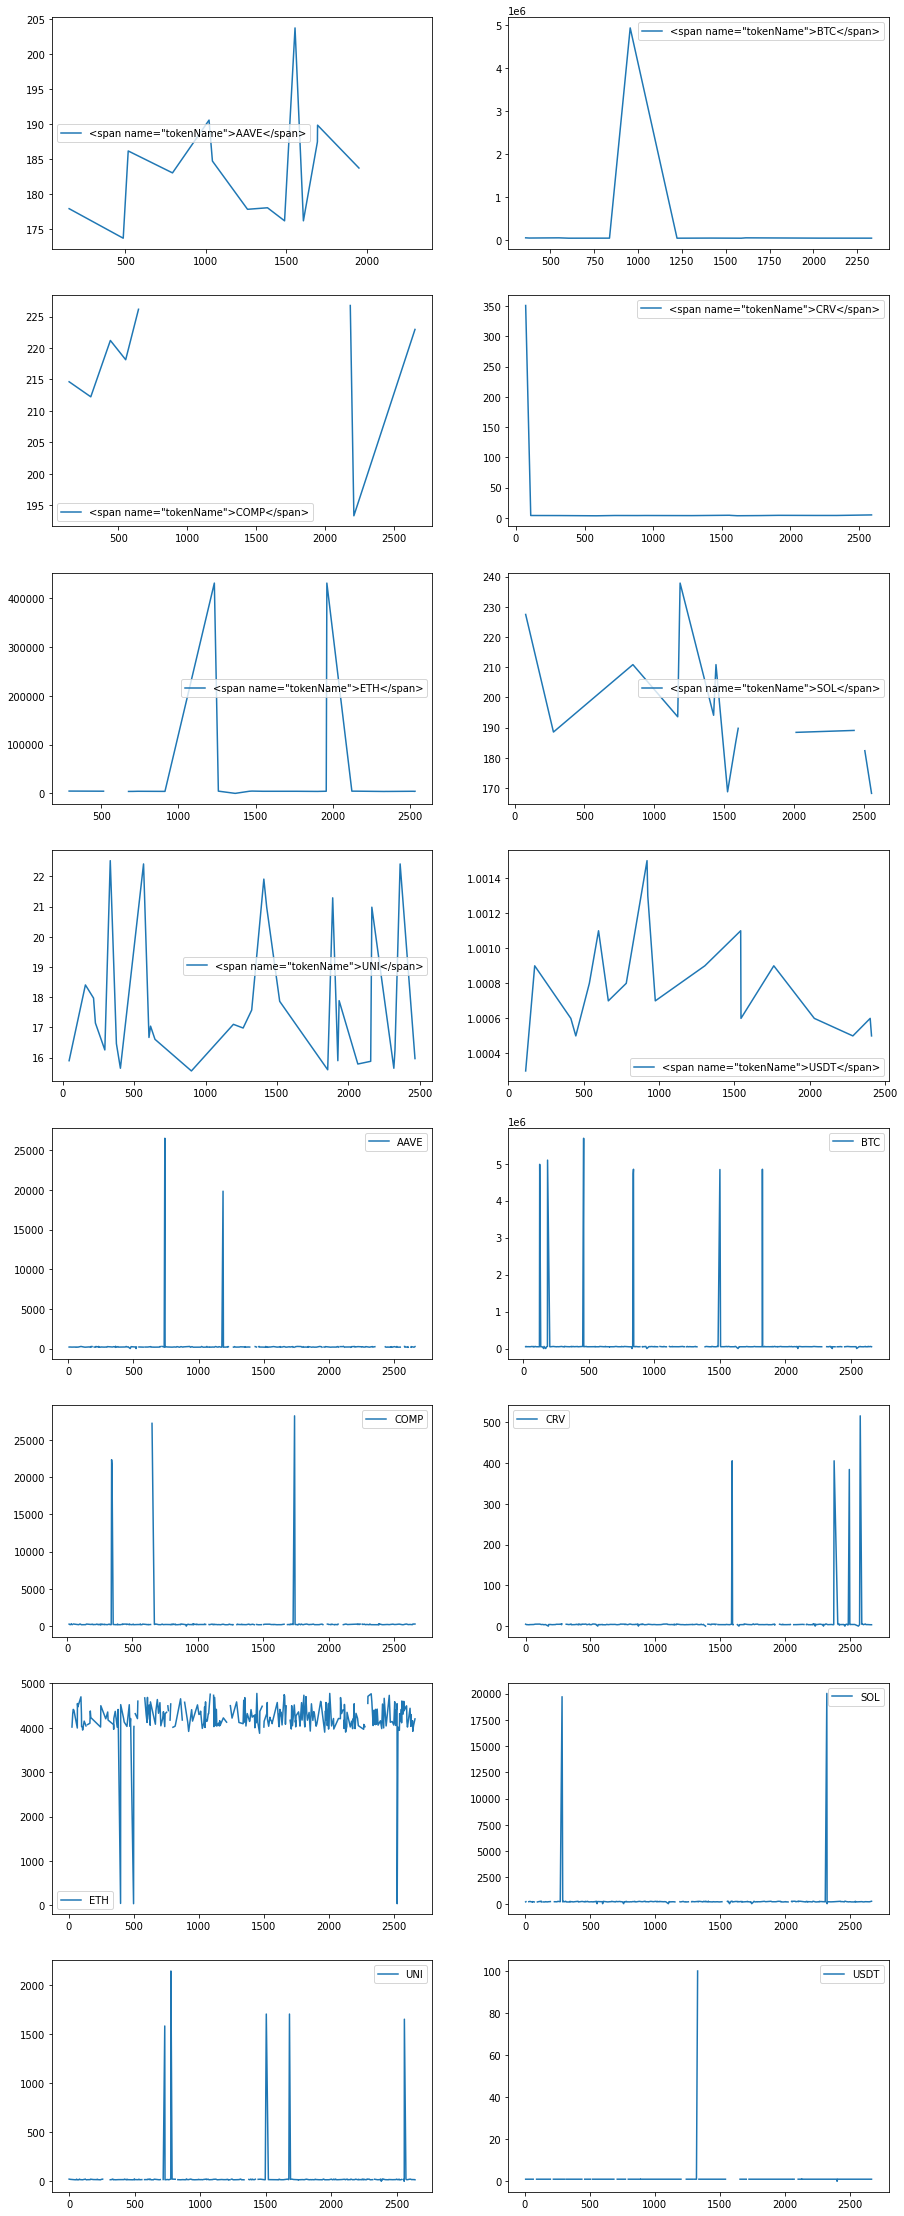

In [184]:
plot(df,'close')

In [185]:
#In this way, i find that the dataset have some problem
#1. There are some duplicates in the dataset
#2. The token name is not all well-formated
#3. There are some outliers and null value for some columns

In [186]:
#drop duplicates
df = df.drop_duplicates()

In [187]:
#adjust the token name
df.loc[df.token.str.contains('<span name="tokenName">'),'token'] = df.loc[df.token.str.contains('<span name="tokenName">'),'token'].str.extract('<span name="tokenName">(.|\n)*?<\/span>')
df.token.value_counts()

COMP    286
BTC     283
SOL     281
AAVE    280
CRV     279
USDT    278
UNI     270
ETH     270
Name: token, dtype: int64

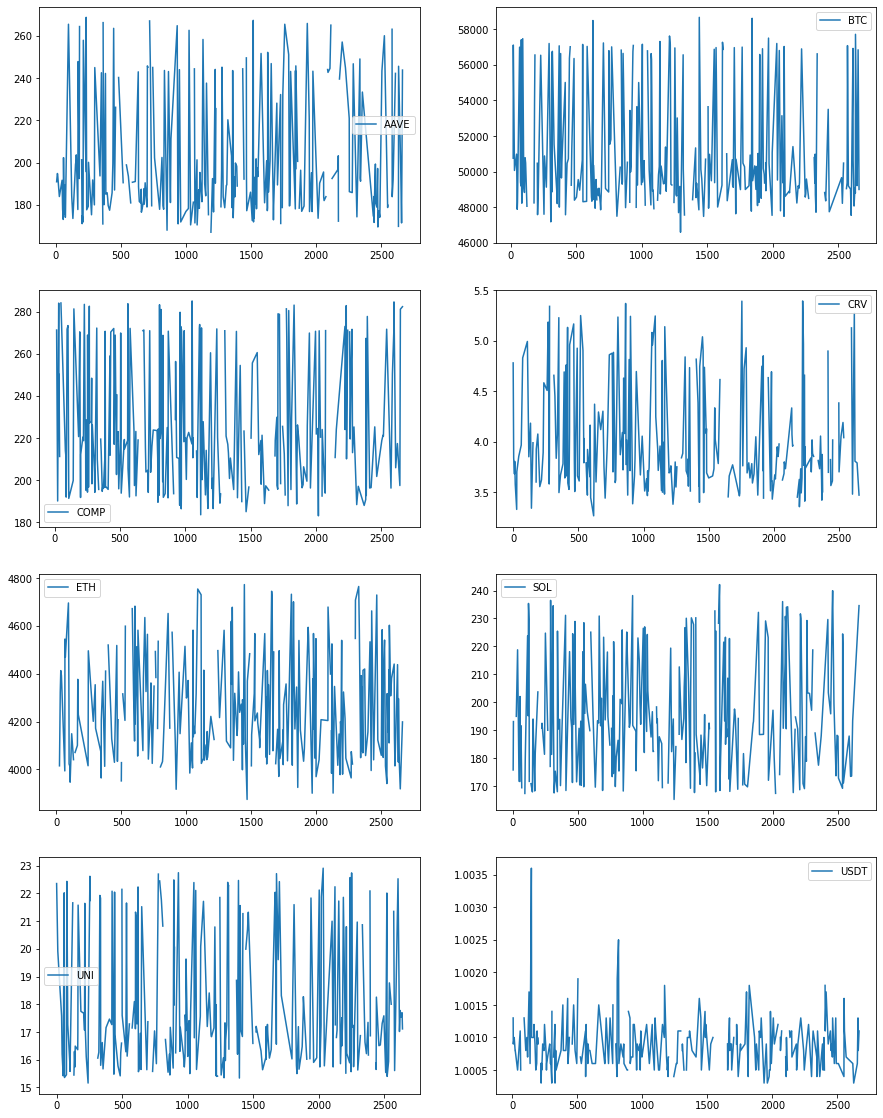

In [188]:
#remove the outliers
df.loc[(df.close/df.open>2)|(df.open/df.close>2),'close'] = np.nan
plot(df,'close')

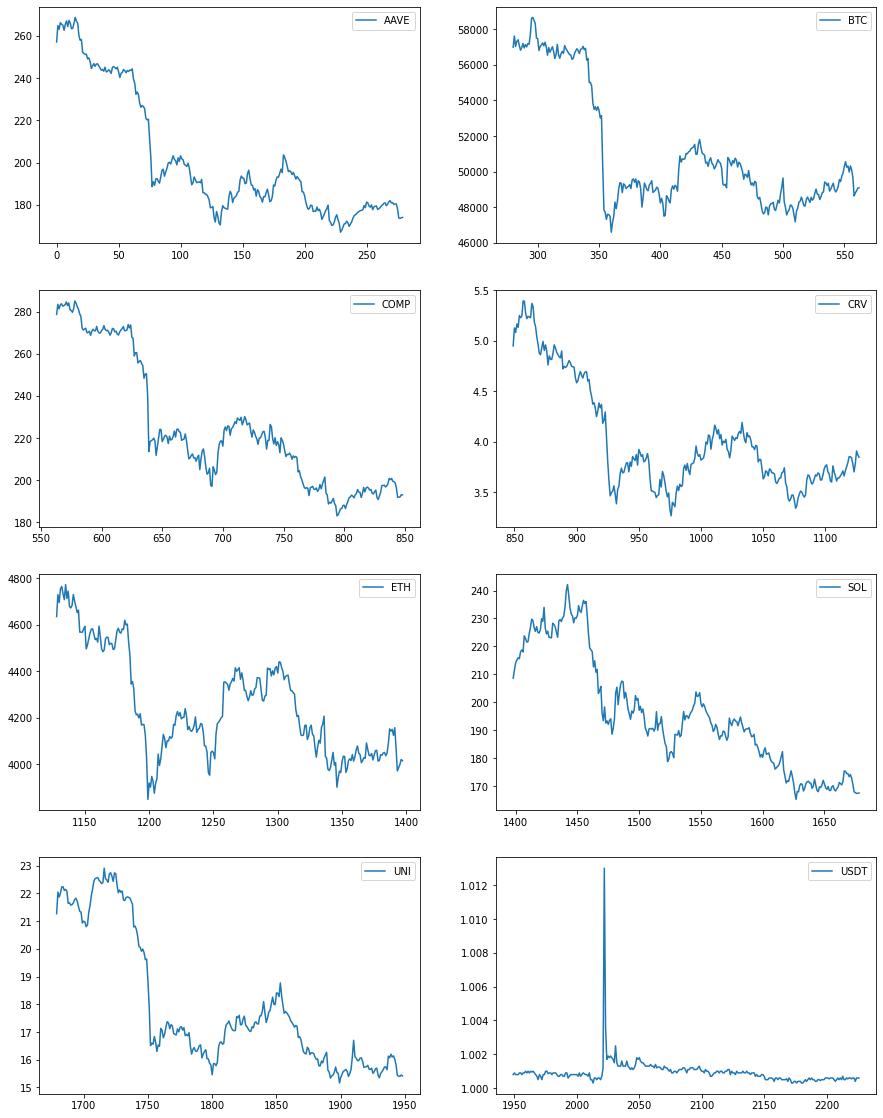

In [189]:
#fill the empty values
#first, fill the empty high and low value by token using ffill method,
#then fill the empty close price value with the average of high and low value
def fill_func(df):
    df_ts = df.set_index('ts').sort_index()
    return df_ts.assign(high=df_ts.high.fillna(method='ffill'),low=df_ts.low.fillna(method='ffill'))
df = df.groupby('token',as_index=False).apply(fill_func).reset_index()
#df.loc[pd.isnull(df.close),'close'] = (df.loc[pd.isnull(df.close),'high']+df.loc[pd.isnull(df.close),'low'])/2
df.loc[pd.isnull(df.close),'close'] = (df.loc[pd.isnull(df.close),'high']+df.loc[pd.isnull(df.close),'low'])/2
plot(df,'close')

In [190]:
#calculate the volumeUSD
df['volumeUSD'] = df['volume']*df['close']

In [191]:
#calculate the sum of volumeUSD by chain
df.groupby('chain')['volumeUSD'].sum()

chain
BTC     1.056051e+10
ETH     1.253563e+10
SOL     3.912560e+09
USDT    9.696403e+08
Name: volumeUSD, dtype: float64